In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from alibi.explainers import ALE, plot_ale
import matplotlib.pyplot as plt
import shap
#df1 =pd.read_csv("~/data/Feature_importance_comparison.csv")
#df2 = pd.read_csv("~/data/Feature_importance_comparison2.csv")


In [ ]:
def gen_data1():
  n = 1000

  # Mean of the variables
  mean = [0, 0, 0, 0]

  c01 = c10 =0.9
  c12 = c21 = 0.7
  c13= c31 = 0.5
  c23= c32 = 0.5
  c03 = c30 = 0.5
  c02 = c20 = 0.5
  # Variance-covariance matrix of the variables
  cov = [[1, c10, c20, c30],
        [c01, 1, c21, c31],
        [c02,c12, 1, c32],
        [c03, c13, c23, 1]]

  # Generate correlated synthetic data
  data = np.random.multivariate_normal(mean, cov, size=n)
  var_0, var_1, var_2, var_3 = data.T

  X = pd.DataFrame({'var_0': var_0, 'var_1': var_1, 'var_2': var_2, 'var_3': var_3})
  #y = X["var_0"] + np.random.normal(scale=0.1, size=(1000,))
  y = (X["var_0"] + np.random.normal(scale=0.1, size=(1000,))>0).astype(int)
  return (X, y)

In [ ]:
def gen_data2():
  np.random.seed(int(time.time()))
  X = np.random.normal(size=(10000, 5))
  X[:, 0] = X[:, 1] + np.random.normal(scale=0.1, size=(10000,))
  X[:, 2] = X[:, 1] + np.random.normal(scale=0.1, size=(10000,))
  X[:, 3] =   X[:, 0] + np.random.normal(scale=0.5, size=(10000,))
  y = ( X[:, 0] > 0).astype(int)
  X = pd.DataFrame(X)
  return (X,y)

In [ ]:
def get_shap(model, X):
  explainerShap = shap.Explainer(model.predict, X)
  shap_values = explainerShap(X)
  vector = []
  for i in range(X.shape[1]):
    value = abs(shap_values.values[:, i]).mean()
    vector.append(value)
  #print(shap.summary_plot(shap_values, X, plot_type="bar"))
  return vector

def get_shapTreeRegressor(model, X):
  explainerTree = shap.TreeExplainer(model).shap_values(X)
  vector = []
  for i in range(X.shape[1]):
    value = abs(explainerTree[:, i]).mean()
    vector.append(value)
  #print(shap.summary_plot(explainerTree, X, plot_type="bar"))
  return vector

def get_shapTree(model, X):
  explainerTree = shap.TreeExplainer(model).shap_values(X)
  )
  vector = np.mean(np.abs(explainerTree[0]), axis=0)
  print(shap.summary_plot(explainerTree, X, plot_type="bar"))
  return  vector

def get_FeatImport(model, X):
  vector = model.feature_importances_
  #print(plt.bar(range(X.shape[1]),model.feature_importances_))
  return vector

def get_ALE_max(model, X, names):
  proba_fun = model.predict_proba
  proba_ale = ALE(proba_fun, feature_names=names, target_names=["y"])
  proba_exp = proba_ale.explain(X.values)
  vector = []
  for i in range(X.shape[1]):
    value = abs(proba_exp.ale_values[i][:,0]).max()
    vector.append(value)
  #print(plot_ale(proba_exp))
  return vector

In [ ]:
# Number of iterations
n_iter = 20

# Create an empty list to store the feature importances of each iteration
feature_imp_list = []
models=[RandomForestClassifier(n_estimators=100, random_state=0)]
#feature_imp_list = []
# Create an empty dataframe to store the results
feature_imp_df = pd.DataFrame(columns=["Iteration", "Algorithm", "Metric", "A", "B", "C", "D"])

# Loop through each model and iteration
for model in models:
  for i in range(n_iter):
      name_classifier = type(model).__name__
      # Generate a sample dataframe
      X,y = gen_data2()
      names = X.columns.tolist()
      #model = model
      model =model.fit(X, y)
      
      # Compute feature importance for each variable using algorithm 1
      feature_imp_1 = get_shapTree(model, X)
      
      # Compute feature importance for each variable using algorithm 2
      feature_imp_2 = get_ALE_max(model, X, names)
      
      # Compute feature importance for each variable using algorithm 3
      feature_imp_3 = get_FeatImport(model, X)
      
      # Store the results for algorithm 1 in a dataframe
      temp_df1 = pd.DataFrame({"Iteration": [i], "Algorithm": [name_classifier], "Metric": ["TreeShap"], 
                              "A": [feature_imp_1[0]], "B": [feature_imp_1[1]], 
                              "C": [feature_imp_1[2]], "D": [feature_imp_1[3]], 
                               "RelVar1": [(((sum(feature_imp_1) - feature_imp_1[0])/feature_imp_1[0])-1)*-1]})
      feature_imp_df = pd.concat([feature_imp_df, temp_df1])
      
      # Store the results for algorithm 2 in a dataframe
      temp_df2 = pd.DataFrame({"Iteration": [i], "Algorithm": [name_classifier], "Metric": ["ALE-based"], 
                              "A": [feature_imp_2[0]], "B": [feature_imp_2[1]], 
                              "C": [feature_imp_2[2]], "D": [feature_imp_2[3]],
                               "RelVar1": [(((sum(feature_imp_2) - feature_imp_2[0])/feature_imp_2[0])-1)*-1]})
      feature_imp_df = pd.concat([feature_imp_df, temp_df2])
      
      # Store the results for algorithm 3 in a dataframe
      temp_df3 = pd.DataFrame({"Iteration": [i], "Algorithm": [name_classifier], "Metric": ["Feat_Imp."], 
                              "A": [feature_imp_3[0]], "B": [feature_imp_3[1]], 
                              "C": [feature_imp_3[2]], "D": [feature_imp_3[3]],
                               "RelVar1": [(((sum(feature_imp_3) - feature_imp_3[0])/feature_imp_3[0])-1)*-1]})
      feature_imp_df = pd.concat([feature_imp_df, temp_df3])

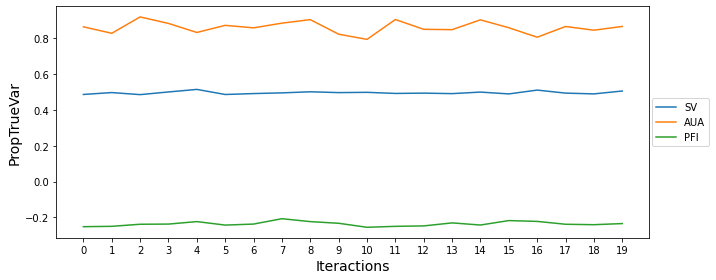

In [11]:
fig = plt.figure(figsize=(10, 4))
df1.Iteration = df1.Iteration.astype(str)
sns.lineplot(x="Iteration", y="RelVar1", hue="Metric", data=df1.reset_index(drop=True))
plt.xlabel("Iteractions", fontsize=14)
plt.ylabel("PropTrueVar", fontsize=14)

#plt.xticks(np.arange(1, 20, 1))
# Improve image quality
#plt.legend()
plt.legend(loc="center right", bbox_to_anchor=(1.11, 0.5), labels=['SV', 'AUA', 'PFI'])
plt.tight_layout()
plt.savefig('Prop_true_var.png', dpi=400)  
plt.show()
#plt.savefig("/content/drive/My Drive/PropTrueVar.png", dpi=400)

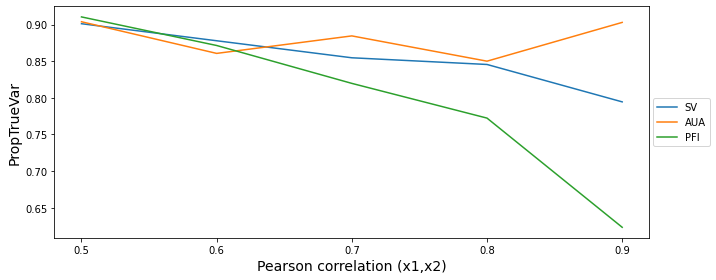

In [13]:
fig = plt.figure(figsize=(10, 4))
df2.Correlation = df2.Correlation.astype(str)
sns.lineplot(x="Correlation", y="RelVar1", hue="Metric", data=df2.reset_index(drop=True))
plt.xlabel("Pearson correlation (x1,x2)", fontsize=14)
plt.ylabel("PropTrueVar", fontsize=14)
plt.legend(loc="center right", bbox_to_anchor=(1.11, 0.5), labels=['SV', 'AUA', 'PFI'])
#plt.xticks(np.arange(1, 20, 1))
# Improve image quality
plt.tight_layout()

plt.savefig("PropTrueVarDiffCorr.png", dpi=400)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb


X = [[1, 1]]*4500 + [[0, 0]]*4500 + [[1, 0]]*500 + [[0, 1]]*500
X = pd.DataFrame(X, columns = ["f0", "f1"])
y = X.sum(axis = 1)

#xgb_model = xgb.XGBRegressor(objective="reg:squarederror" ,random_state=42,max_depth=2)
#xgb_model = GradientBoostingRegressor(random_state=42,max_depth=3)
xgb_model = RandomForestRegressor(random_state=42,max_depth=3)
xgb_model.fit(X, y)
y_pred = xgb_model.predict(X)


explainer = shap.TreeExplainer(xgb_model, X,  feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="bar")


#Plot
proba_fun_rf = xgb_model.predict
proba_ale_rf = ALE(proba_fun_rf, feature_names=["f1","f2"], target_names=["y"])
proba_exp_rf = proba_ale_rf.explain(X.values)
plot_ale(proba_exp_rf)

#xgb.plot_importance(xgb_model)


print("ratio for SHAP:", shap_values[0][0]/ shap_values[0][1])
importance_dict = xgb_model.get_booster().get_fscore()
importance_vector = [importance_dict.get(f, 0) for f in xgb_model.get_booster().feature_names]
print("ration feature importance",importance_vector[0]/importance_vector[1])
print("ratio ALE value:", proba_exp_rf.ale_values[0][1]/proba_exp_rf.ale_values[1][1])
#print("ratio feature importance", xgb_model.feature_importances_[0] /xgb_model.feature_importances_[1])